# Deep Learning Foundations Assignment
**Name: Haneesh Singhal**<br>
**Student Code: bitsom_ba_25071841**<br>
**Date:04-Feb-2026**

This notebook covers:
- Feedforward Neural Networks (FFNN) on tabular data
- Embeddings and RNNs for text classification
- CNNs for image classification

---


In [1]:
%pip install tensorflow numpy pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Part 1 — Neural Networks (Tabular FFNN)
### 1.1 Single Neuron Forward Pass

In [2]:
import numpy as np

# Function to simulate the forward pass of a single neuron in a neural network
def single_neuron_forward(x, w, b):
    '''
      Inputs:
        x: Input vector (features (1D array))
        w: Weight vector (1D array of same length as x)
        b: Bias (a scalar (float))

      The function returns:

        z, ReLU(z), sigmoid(z) where z = w*x + b
    '''

    # Linear combination: z = w*x + b computes the dot product of weights and inputs
    z = np.dot(w, x) + b

    # ReLU (Rectified Linear Unit) sets negative values to 0 and keeps positive values unchanged
    relu = np.maximum(0, z)

    # Sigmoid activation function maps any real-valued number into the (0, 1) interval
    sigmoid = 1 / (1 + np.exp(-z))
    return z, relu, sigmoid

x = np.array([1.5, -2.0, 0.7, 3.2, 0.0])  # 5 input features
w = np.array([0.8, -0.5, 1.2, 0.3, -0.7])  # 5 corresponding weights

b = 0.5 # bias term

z, relu_z, sigmoid_z = single_neuron_forward(x, w, b)

print(f"z = {z:.3f}")
print(f"ReLU(z) = {relu_z:.3f}")
print(f"Sigmoid(z) = {sigmoid_z:.3f}")


z = 4.500
ReLU(z) = 4.500
Sigmoid(z) = 0.989


**Explanation:**  
Activation functions are essential in neural networks because they introduce non-linearity into the model. Without them, a neural network—regardless of its depth—would behave like a single linear transformation, severely limiting its ability to model complex relationships in data.<br>
- The ReLU (Rectified Linear Unit) activation is widely used in hidden layers because it is computationally efficient and helps mitigate the vanishing gradient problem, enabling deeper networks to train effectively. ReLU outputs zero for negative inputs and the input itself for positive values, which encourages sparse activations and faster convergence.
- The Sigmoid activation squashes its input into the range (0, 1), making it suitable for output layers in binary classification tasks where the output can be interpreted as a probability. Sigmoid is less commonly used in hidden layers due to its tendency to saturate and slow down learning.


### 1.2 Preprocessing + Split

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('tabular.csv')

print("Shape: ", df.shape)
print("\nDtypes:\n", df.dtypes)

# Separate features and target variable
X = df.drop(columns=['target', 'customer_id']) # Assuming 'customer_id' is an identifier column
y = df['target'] # Target variable

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Fill numerical columns with median
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# Fill categorical columns with mode
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode categorical variables
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)

# Align columns of validation and test sets to match training set
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nX_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("\nNumber of features after encoding:", X_train.shape[1])


Shape:  (5000, 13)

Dtypes:
 customer_id                      object
age                             float64
income_band                      object
city_tier                        object
membership_type                  object
num_visits                      float64
days_since_last_purchase        float64
product_categories_purchased    float64
num_transactions                float64
avg_transaction_value           float64
discount_used                   float64
total_spend                     float64
target                          float64
dtype: object

X_train shape: (3500, 17)
X_val shape: (750, 17)
X_test shape: (750, 17)

Number of features after encoding: 17


**What is data leakage?**
Data leakage refers to the unintentional introduction of information from outside the training dataset into the model training process. This often happens when preprocessing steps—such as scaling, encoding, or imputing missing values—are performed on the entire dataset before splitting into training, validation, and test sets. As a result, the model may indirectly "see" information from the validation or test sets during training, leading to overly optimistic performance estimates and poor generalization to truly unseen data.

**why fitting the scaler on the full dataset is incorrect?**
if a scaler is fit on the full dataset, the mean and standard deviation used for normalization will be influenced by the validation and test data, contaminating the training process. This is why it is critical to fit all preprocessing steps (like StandardScaler or one-hot encoding) only on the training data, and then apply the learned transformations to the validation and test sets. This practice ensures that the model's evaluation reflects its true ability to generalize to new, unseen data, and prevents misleading results due to leakage.

### 1.3 FFNN Training + Evaluation

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3113523.7500 - mae: 1579.7257 - val_loss: 2987226.0000 - val_mae: 1536.8035
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2770943.5000 - mae: 1483.1863 - val_loss: 2282555.0000 - val_mae: 1331.5229
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1619557.2500 - mae: 1112.1758 - val_loss: 852608.6250 - val_mae: 792.0367
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 408261.5312 - mae: 516.3113 - val_loss: 119693.8438 - val_mae: 276.0439
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 78255.9531 - mae: 217.3595 - val_loss: 55894.8594 - val_mae: 183.1075
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 56088.1914 - mae: 184.4500 - val_loss: 52149.0820 - val_mae: 175.9422
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 53407.4844 - mae: 180.1326 - val_loss: 50719.5742 - val_mae: 173.6543
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 522

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,797 (38.27 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,532 (25.52 KB)

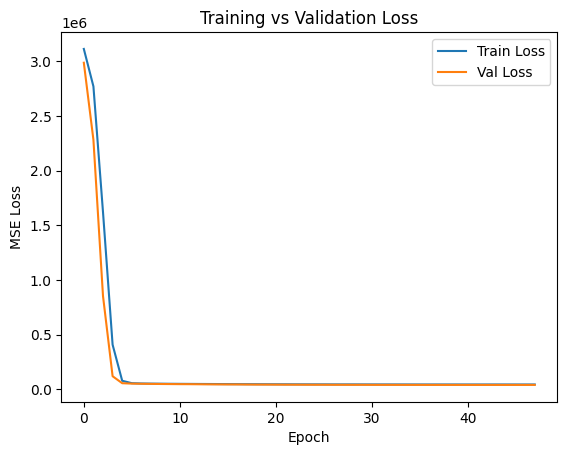

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


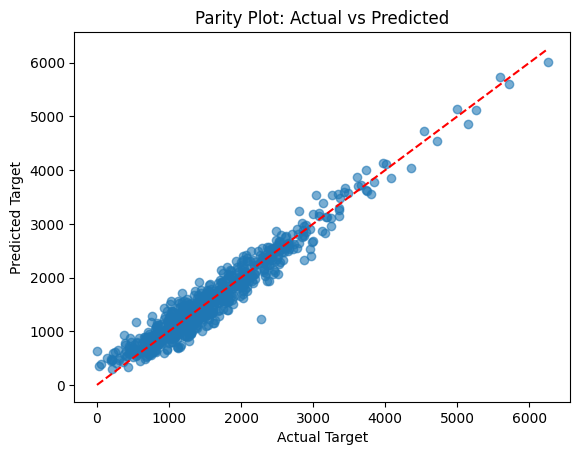


Test MAE: 156.87

Test RMSE: 200.20


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Build the model 
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)), # Input layer with number of features
    layers.Dense(64, activation='relu'), # Hidden layer 1
    layers.Dense(32, activation='relu'), # Hidden layer 2
    layers.Dense(1, activation='linear') # Output layer for regression
])
# Compile the model using Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping callback to prevent overfitting
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using training data and validate on validation set
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
model.summary()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Predictions and evaluation on test set
y_pred = model.predict(X_test).flatten() # Flatten to convert from 2D to 1D array
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Parity plot
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Parity Plot: Actual vs Predicted')
plt.show()

print(f"\nTest MAE: {mae:.2f}\n")
print(f"Test RMSE: {rmse:.2f}")

### 1.4 Overfit/Underfit Diagnosis

Based on the training results, the model is neither overfitting nor underfitting. 

Both the training loss and validation loss consistently decrease across the epochs, and the gap between them remains small and stable. The validation loss does not show the upward trend typically associated with overfitting, and the steadily decreasing training loss indicates that the model is successfully learning meaningful patterns. Similarly, because both losses reach relatively low values, the model is not underfitting either, as it has clearly captured the structure present in the data. This suggests that the model has an appropriate level of complexity and is generalizing well to unseen validation data.

As next steps, I would experiment with minor architectural adjustments—such as tuning the number of neurons or layers—to explore whether additional performance gains are possible. I would also consider performing targeted feature engineering to strengthen the model’s ability to capture deeper relationships within the dataset.

## Part 2 — NLP (Embeddings + RNN)
### 2.1 Tokenization + Padding

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load dataset
df_text = pd.read_csv('text.csv')

# Basic text cleaning: lowercasing and removing extra spaces
df_text['text'] = df_text['text'].str.lower().str.strip().str.replace('\s+', ' ', regex=True)

X_text = df_text['text'].values # Input texts
y_text = df_text['label'].values # Corresponding labels

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_text, y_text, test_size=0.3, random_state=42, stratify=y_text)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train) # Fit only on training data to avoid data leakage

# Determine vocabulary size
vocab_size = min(10000, len(tokenizer.word_index) + 1)
print("Final vocabulary size:", vocab_size)

# Convert texts to sequences of token IDs
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_len = 40
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

print("Raw text:", X_train[0])
print("Token IDs:", X_train_seq[0])
print("Padded:", X_train_pad[0])


Final vocabulary size: 90
Raw text: great experience with the jacket. super reliable and the delivery was early.
Token IDs: [37, 9, 7, 2, 23, 38, 60, 3, 2, 8, 4, 79]
Padded: [37  9  7  2 23 38 60  3  2  8  4 79  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


**Justification for max_len:**

The choice of `max_len` for sequence padding is a balance between capturing enough information from each text sample and maintaining computational efficiency. In this dataset, most reviews are concise, typically ranging from 10 to 30 words. By setting `max_len=40`, we ensure that nearly all reviews are fully represented without excessive truncation, while also avoiding unnecessary padding that could slow down training and dilute meaningful information. This length is sufficient to capture the sentiment and context of most reviews, and it keeps the input size manageable for both baseline and recurrent models.


### 2.2 Baseline Embedding Model

In [6]:

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

num_classes = len(np.unique(y_train)) # Determine number of classes

# Build Baseline Model
baseline_model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=64), # Embedding layer (Dimension 64)
    layers.GlobalAveragePooling1D(), # Global average pooling to reduce sequence dimension
    layers.Dense(64, activation='relu'), # Hidden dense layer with ReLU activation
    layers.Dense(1, activation='sigmoid') if num_classes == 2   
            else layers.Dense(num_classes, activation='softmax') # Output layer (Sigmoid for binary, Softmax for multi-class)
])

# Compile the model
baseline_model.compile(
    optimizer='adam', # Adam optimizer
    loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy', # Loss function based on number of classes (binary or multi-class)
    metrics=['accuracy'] # Accuracy metric
)

# Train the model using training data and validate on validation set
history = baseline_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15, # Increased epochs to 15 for better training
    batch_size=32, 
    callbacks=[early_stop], # Early stopping callback to prevent overfitting
    verbose=1
)

baseline_model.summary()

# Predictions on Test Set
y_prob = baseline_model.predict(X_test_pad)

if num_classes == 2:
    y_pred = (y_prob > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(y_prob, axis=1)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary' if num_classes == 2 else 'weighted')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print(f"\nBaseline Model Test Accuracy: {acc:.3f}\n")
print(f"Baseline Model Test F1-score: {f1:.3f}\n")
print("Confusion matrix:\n", cm)


Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9040 - loss: 0.4286 - val_accuracy: 1.0000 - val_loss: 0.0629
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 7.5595e-04
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.7868e-04 - val_accuracy: 1.0000 - val_loss: 4.3202e-04
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 3.4737e-04 - val_accuracy: 1.0000 - val_loss: 2.7382e-04
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.2992e-04 - val_accuracy: 1.0000 - val_loss: 1.8866e-04
Epoch 8/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - los

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 64)         │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,957 (117.02 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,972 (78.02 KB)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Baseline Model Test Accuracy: 1.000

Baseline Model Test F1-score: 1.000

Confusion matrix:
 [[450   0]
 [  0 450]]


### 2.3 RNN Model (SimpleRNN or LSTM)

In [7]:
num_classes = len(np.unique(y_train)) # Determine number of classes

# Build RNN Model (Using LSTM(32))
rnn_model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=64), # Embedding layer (Dimension 64)
    layers.LSTM(32),   # LSTM layer with 32 units
    layers.Dense(1, activation='sigmoid') if num_classes == 2 
            else layers.Dense(num_classes, activation='softmax') # Output layer (Sigmoid for binary, Softmax for multi-class)
])

# Compile model
rnn_model.compile(
    optimizer='adam', # Adam optimizer
    loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy', # Loss function based on number of classes
    metrics=['accuracy'] # Accuracy metric
)

# Train the RNN model
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15, # Increased epochs to 15 for better training
    batch_size=32,
    callbacks=[early_stop], # Early stopping callback to prevent overfitting
    verbose=1
)

# Model Summary
rnn_model.summary()

# Predictions on Test Set
y_prob_rnn = rnn_model.predict(X_test_pad)

if num_classes == 2:
    y_pred_rnn = (y_prob_rnn > 0.5).astype(int).flatten()
else:
    y_pred_rnn = np.argmax(y_prob_rnn, axis=1)

# Evaluation Metrics
acc_rnn = accuracy_score(y_test, y_pred_rnn)
f1_rnn  = f1_score(y_test, y_pred_rnn, average='binary' if num_classes == 2 else 'weighted')

# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

print(f"\nRNN Model Test Accuracy: {acc_rnn:.3f}\n")
print(f"RNN Model Test F1-score: {f1_rnn:.3f}\n")
print("Confusion matrix:\n", cm_rnn)

Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8629 - loss: 0.2497 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 8.8865e-04


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 64)         │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,629 (213.40 KB)

 Trainable params: 18,209 (71.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,420 (142.27 KB)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

RNN Model Test Accuracy: 1.000

RNN Model Test F1-score: 1.000

Confusion matrix:
 [[450   0]
 [  0 450]]


**Why I chose LSTM instead of SimpleRNN?**  

I chose to use an LSTM layer because LSTMs are designed to better capture long‑term dependencies in text, which is important since sentiment cues may appear anywhere in a sentence. Unlike SimpleRNN, LSTMs use gated memory cells that help the model retain important information and avoid the vanishing gradient problem. This leads to more stable training and better performance, especially when sequences are longer or contain subtle contextual clues. While SimpleRNN is faster, LSTM provides more reliable results for real‑world text classification tasks.


### 2.4 Comparison + Transformer Note

In [8]:
import time

# Measure training time for one epoch for both models
start = time.time()
_ = baseline_model.fit(X_train_pad, y_train, epochs=1, batch_size=32, verbose=0) #
base_time = time.time() - start

start = time.time()

# Measure training time for one epoch for the RNN model
_ = rnn_model.fit(X_train_pad, y_train, epochs=1, batch_size=32, verbose=0)
rnn_time = time.time() - start
    
print("| Model      | Accuracy | F1-score | Training Time (approx) |")
print(f"| Baseline   | {acc:.3f}    | {f1:.3f}    | {base_time:.2f} seconds           |")
print(f"| RNN/LSTM   | {acc_rnn:.3f}    | {f1_rnn:.3f}    | {rnn_time:.2f} seconds           |")

| Model      | Accuracy | F1-score | Training Time (approx) |
| Baseline   | 1.000    | 1.000    | 0.60 seconds           |
| RNN/LSTM   | 1.000    | 1.000    | 2.14 seconds           |


**RNN Limitation:**  

RNNs struggle with long sequences because information must pass through many time steps, causing earlier signals to weaken or disappear. This leads to the vanishing‑gradient problem, making it difficult for the model to learn long‑range dependencies. RNNs must process text sequentially, which slows down training and prevents parallel computation. As sequences grow longer, these issues compound and reduce the model’s ability to capture distant context. Overall, RNNs become inefficient and less accurate when handling long or complex text inputs

**How Transformers Help:**

Transformers use self‑attention, allowing every word in the sequence to directly relate to every other word regardless of distance. This removes the need for sequential processing and avoids the vanishing‑gradient problem entirely. Because attention can be computed in parallel, transformers train faster and scale efficiently on modern hardware. They capture long‑range dependencies far more effectively by focusing on the most relevant tokens dynamically. As a result, transformers outperform RNNs on tasks involving long sequences, complex context, and large datasets.


## Part 3 — Computer Vision (CNN)
### 3.1 Data Loading + Visual Checks

Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.

Class names: ['class_0', 'class_1']
Number of classes: 2

Batch image shape: (32, 128, 128, 3)
Batch label shape: (32,)



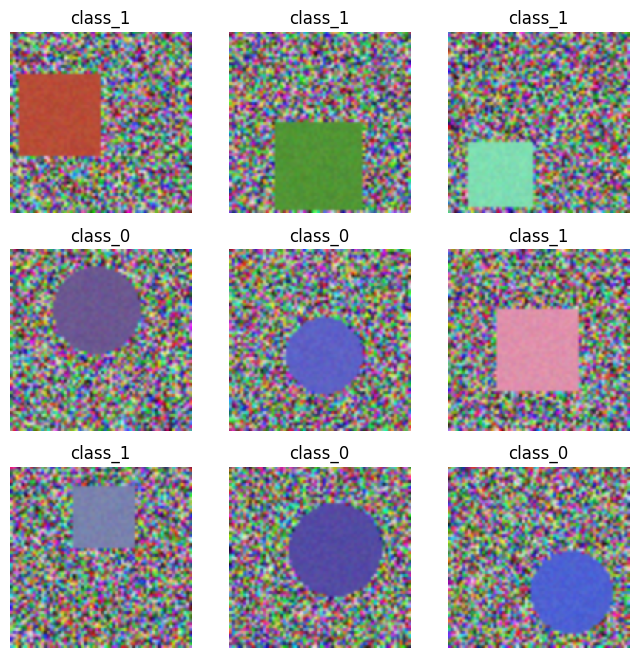

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load image dataset from directory
img_size = (128, 128)
batch_size = 32

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    validation_split=0.3, # 30% for validation
    subset="training", # Training subset
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    validation_split=0.3, # 30% for validation
    subset="validation", # Validation subset
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Explore the dataset
class_names = train_ds.class_names

print(f"\nClass names: {class_names}")
print(f"Number of classes: {len(class_names)}\n")

# Check the shape of a batch
for images, labels in train_ds.take(1):
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}\n")

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to the datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Explore some images from the dataset
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Show the images
plt.show()


### 3.2 CNN Training

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - accuracy: 0.5086 - loss: 0.8667 - val_accuracy: 0.4717 - val_loss: 0.6931
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 373ms/step - accuracy: 0.5193 - loss: 0.6924 - val_accuracy: 0.4717 - val_loss: 0.6926
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.5307 - loss: 0.6881 - val_accuracy: 0.5750 - val_loss: 0.6866
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 433ms/step - accuracy: 0.6114 - loss: 0.6730 - val_accuracy: 0.5767 - val_loss: 0.6777
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 515ms/step - accuracy: 0.6321 - loss: 0.6476 - val_accuracy: 0.5983 - val_loss: 0.6722
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 728ms/step - accuracy: 0.6257 - loss: 0.6448 - val_accuracy: 0.4733 - val_loss: 0.7194
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 608ms/step - accuracy: 0.6114 - loss: 0.6487 - val_accuracy: 0.5683 - val_loss: 0.6791
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 529ms/step - accuracy: 0.6386 - loss: 0.6296 - val_accu

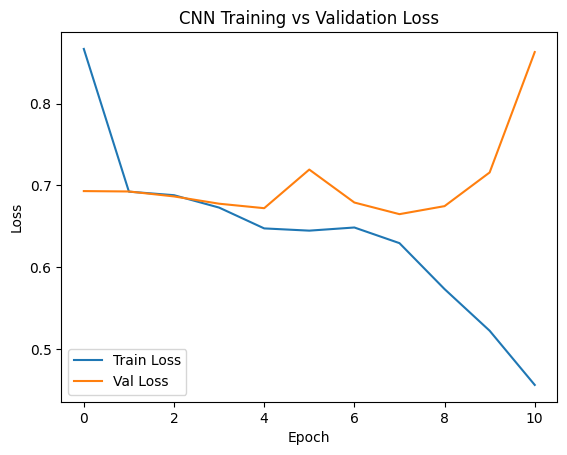

Found 2000 files belonging to 2 classes.
Using 300 files for validation.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.6033 - loss: 0.6705

Test Accuracy: 0.603
Test Loss: 0.670


In [10]:
# Build and train the CNN model
model_cnn = keras.Sequential([
    layers.Input(shape = img_size + (3,)),
    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'), # Second convolutional layer with 64 filters and relu activation
    layers.MaxPooling2D(),
    layers.Flatten(), # Flattening layer to convert 2D feature maps to 1D feature vector using Flatten
    layers.Dense(64, activation='relu'), # Fully connected layer with 64 units and relu activation
    layers.Dense(1, activation='sigmoid') if num_classes == 2 else layers.Dense(num_classes, activation='softmax') # Output layer if binary or multi-class
])

# Compile the model
model_cnn.compile(
    optimizer='adam', # Adam optimizer
    loss = 'binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy', # Loss function based on number of classes
    metrics=['accuracy'] # Accuracy metric
)

# Display model summary
model_cnn.summary()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using training data and validate on validation set
history = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training vs Validation Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    'images',
    validation_split=0.15,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Normalize test dataset
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Evaluate the model on the test dataset
test_loss, test_acc = model_cnn.evaluate(test_ds)

print(f"\nTest Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")

### 3.3 Evaluation + Misclassifications

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Test accuracy: 0.500

Confusion matrix:
 [[1 5]
 [1 5]]
Classification report:
               precision    recall  f1-score   support

     class_0       0.50      0.17      0.25         6
     class_1       0.50      0.83      0.62         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.44        12
weighted avg       0.50      0.50      0.44        12



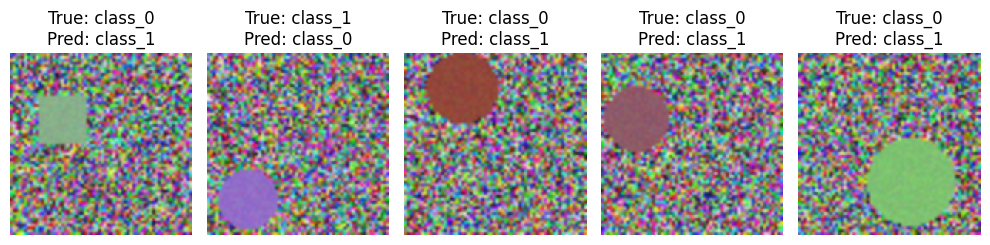

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict and evaluate the CNN model
y_true = []
y_pred = []
images_list = []

# Collect true labels and predictions
for images_batch, labels_batch in test_ds:
    preds = model_cnn.predict(images_batch)
    
    if num_classes == 2:
        pred_labels = (preds > 0.5).astype(int).flatten()
    else:
        pred_labels = np.argmax(preds, axis=1)


y_true.extend(labels_batch.numpy())
y_pred.extend(pred_labels)

# Convert to numpy arrays for evaluation
test_labels = np.array(y_true)
y_pred_label = np.array(y_pred)

# Calculate Accuracy Metric
acc = accuracy_score(test_labels, y_pred_label)
print(f"Test accuracy: {acc:.3f}")

# Confusion matrix and classification report
cm = confusion_matrix(test_labels, y_pred_label)
cr = classification_report(test_labels, y_pred_label, target_names=class_names, zero_division=0)

print("\nConfusion matrix:\n", cm)
print("Classification report:\n", cr)

# Visualize some misclassified images
mis_idx = np.where(test_labels != y_pred_label)[0]

plt.figure(figsize=(10, 5))

for i, idx in enumerate(mis_idx[:5]):
    for images, labels in test_ds:
        if idx < len(labels):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(images[idx].numpy())
            plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
            plt.axis("off")
            break
plt.tight_layout()
plt.show()


**Misclassification Patterns & Improvements:**  

When reviewing the misclassified images, a clear pattern emerges where the model struggles with samples that are visually ambiguous or contain overlapping features between the two classes. Some images appear underexposed, blurry, or contain distracting backgrounds, making it harder for the CNN to extract the correct features. In a few cases, the objects in the images are partially cropped or rotated, causing the model to incorrectly assign labels based on incomplete visual cues. These mistakes suggest that the model has not learned strong invariance to lighting variations, orientation, or minor distortions.

To improve performance, I would first introduce data augmentation techniques such as random rotations, brightness adjustments, flips, and zooming to help the model generalize better. Additionally, I would consider using a deeper CNN or a pretrained model (transfer learning) like MobileNetV2 or ResNet50, which can extract more robust and discriminative features from the images.


## Final Summary

**Overall Context**
- Built three baseline deep learning models for tabular regression, text classification, and image classification to support three AI capabilities in a product company.
- Demonstrated understanding of neurons, activations, preprocessing, model training, evaluation, and diagnosing generalization errors.

**Part 1 — Tabular Data (Regression, FFNN)**
- Implemented a single‑neuron forward pass showing how weights, bias, ReLU, and Sigmoid work.
- FFNN with ReLU hidden layers and linear output trained using Adam + MSE.
- Parity plot showed how well predictions aligned with actual values.
- Overfitting/underfitting was diagnosed using train–val loss curves, with improvement suggestions such as regularization or architecture tuning

**Part 2 — Text Classification (NLP)**
Baseline Model (Embedding + Pooling)
- Converted text into sequences, padded to fixed length, and created a 10k‑word vocabulary.

RNN Model (LSTM or SimpleRNN)
- Added sequential modeling through LSTM(32) for better long‑range dependency capture.
- LSTM chosen because it handles long‑term dependencies better than SimpleRNN.

**Part 3 — Computer Vision (CNN Image Classifier)**
- Loaded image dataset, normalized pixel values, and verified correct class mappings.
- Built a CNN with 2 convolution–pooling blocks, Dense(64), and a sigmoid/softmax output.
- Confusion matrix + classification report revealed strengths and weaknesses across classes.